<a href="https://colab.research.google.com/github/dikiwahyudi11/UTS-Unstructured-Data-Analysis/blob/main/UTS%20Analisis%20Data%20Tidak%20Terstruktur_Diki%20Wahyudi_2106709131.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UTS Analisis Data Tidak Terstruktur
- Nama: Diki Wahyudi
- NPM: 2106709131
- Program Studi: Statistika

# Import Data

In [ ]:
!wget -P data/ 'https://raw.githubusercontent.com/dikiwahyudi11/UTS-Unstructured-Data-Analysis/main/Sarcasm_Headlines_Dataset.json'

--2024-03-31 15:20:12--  https://raw.githubusercontent.com/dikiwahyudi11/UTS-Unstructured-Data-Analysis/main/Sarcasm_Headlines_Dataset.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5616830 (5.4M) [text/plain]
Saving to: ‘data/Sarcasm_Headlines_Dataset.json’

Sarcasm_Headlines_D 100%[===================>]   5.36M  19.5MB/s    in 0.3s    

2024-03-31 15:20:13 (19.5 MB/s) - ‘data/Sarcasm_Headlines_Dataset.json’ saved [5616830/5616830]



In [ ]:
import json
data_dir = '/content/data/Sarcasm_Headlines_Dataset.json'
data = []
with open(data_dir, 'r') as f:
    for line in f:
        data.append(json.loads(line))

In [ ]:
import pandas as pd
df = pd.DataFrame(data)
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [ ]:
df.shape

(26709, 3)

In [ ]:
df.dtypes

article_link    object
headline        object
is_sarcastic     int64
dtype: object

In [ ]:
# Convert headline ke string
df['headline'] = df['headline'].astype(str)

# Preprocessing

## Hapus Kolom

In [ ]:
df.drop(columns = "article_link", axis = 1, inplace = True)
# Drop kolom yang mengandung article link karena tidak akan dipakai pada analisis selanjutnya
df.head(5)

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


## Cek Missing Values

In [ ]:
df.isnull().sum()

headline        0
is_sarcastic    0
dtype: int64

## Hapus Dokumen Duplikat

In [ ]:
# Inspect apakah ada dokumen duplikat atau tidak
df.duplicated().sum()

107

In [ ]:
# Hapus duplikat
df.drop_duplicates(keep = 'first', inplace = True)
df.describe()

,is_sarcastic
count,26602.000000
mean,0.437975
std,0.496147
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


## Preprocessing Teks

Judul berita ditulis oleh profesional secara formal. Oleh karena itu, untuk tidak menghapus apa pun yang dapat membantu konteks, akan dilakukan beberapa preprocessing dasar (menghapus tanda baca dan menerapkan lemmatisasi).

In [ ]:
import re
import string
def clean_text(sentences):
    # Convert text to lowercase
    text = sentences.lower()
    # Remove \\n
    text = re.sub("\\n", "", text)
    # Remove text in square brackets
    text = re.sub('\[.*?\]', '', text)
    # Removing punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # Removing words containing digits
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
df['headline_cleaned'] = df['headline'].map(clean_text)

### Tokenizing

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
df['headline_cleaned'] = df['headline_cleaned'].apply(word_tokenize)

### Lemmatization

In [ ]:
import numpy as np
lemmatizer = WordNetLemmatizer()
df['headline_cleaned'] = df['headline_cleaned'].apply(lambda x: [lemmatizer.lemmatize(w, 'v') for w in x])
# Joining the words back into a single text
df['headline_cleaned'] = df['headline_cleaned'].apply(lambda x: ' '.join(x))

In [ ]:
df.head()

,headline,is_sarcastic,headline_cleaned
0,former versace store clerk sues over secret 'b...,0,former versace store clerk sue over secret bla...
1,the 'roseanne' revival catches up to our thorn...,0,the roseanne revival catch up to our thorny po...
2,mom starting to fear son's web series closest ...,1,mom start to fear sons web series closest thin...
3,"boehner just wants wife to listen, not come up...",1,boehner just want wife to listen not come up w...
4,j.k. rowling wishes snape happy birthday in th...,0,jk rowling wish snape happy birthday in the mo...


## Periksa Panjang Dokumen

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenize = Tokenizer(oov_token = "<oov>") # Creating Keras Tokenizer object
tokenize.fit_on_texts(df['headline_cleaned']) # Build the vocabulary based on the unique words in headline_cleaned
word_idx = tokenize.word_index #  Mapping words to their respective integer indices, from the fitted tokenizer
df['headline_sequence'] = tokenize.texts_to_sequences(df['headline_cleaned']) # Convert headlines_cleaned into integer sequences using the word index
df['length'] = df['headline_sequence'].apply(len) # Calculate the number of words in each headline

In [ ]:
df = df.sort_values(by = 'length')
df.head()

,headline,is_sarcastic,headline_cleaned,headline_sequence,length
3628,impulse -- ep.9,0,impulse,[7487],1
8641,dear 2017,0,dear,[1254],1
6331,sacred sites,0,sacred sit,"[7474, 456]",2
8445,family business,0,family business,"[105, 321]",2
16232,approved catcalls,0,approve catcall,"[1131, 11392]",2


In [ ]:
df = df[df['length']!=0]

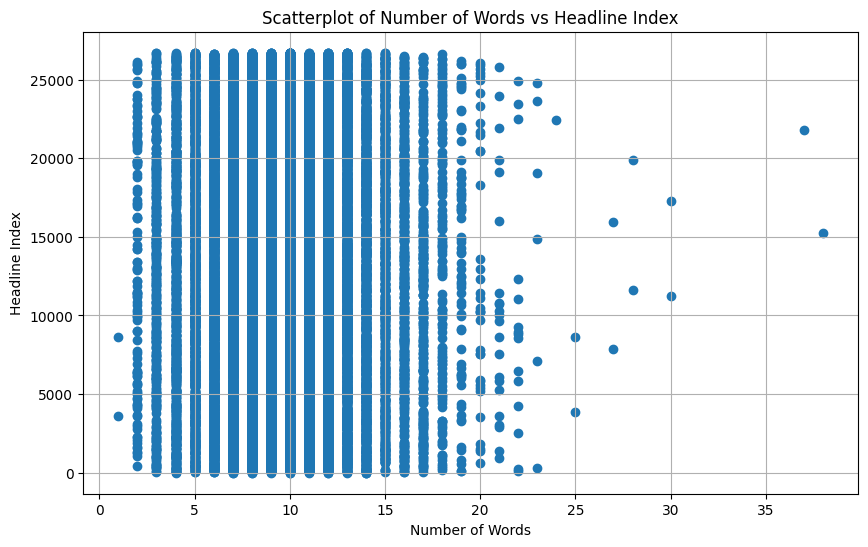

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 6))
plt.scatter(df['length'], df.index)
plt.title('Scatterplot of Number of Words vs Headline Index')
plt.xlabel('Number of Words')
plt.ylabel('Headline Index')
plt.grid(True)
plt.show()

In [ ]:
df['length'].describe()

count    26602.000000
mean         9.686114
std          3.154619
min          1.000000
25%          8.000000
50%         10.000000
75%         12.000000
max         38.000000
Name: length, dtype: float64

Karena panjang dokumen banyak terletak di sekitar 10, maka panjang dokumen yang baik untuk menjadi `max_len` agar tidak banyak nilai 0 adalah 8-13. Untuk project ini akan digunakan `max_len` = 15 agar panjang dokumen yang lebih dari 20 tidak banyak terpotong.

# Visualisasi

## Most Frequent Word in Sarcastic Headlines

In [ ]:
sarcasm_doc = ' '.join(word for word in df[df['is_sarcastic']==1]['headline_cleaned'])

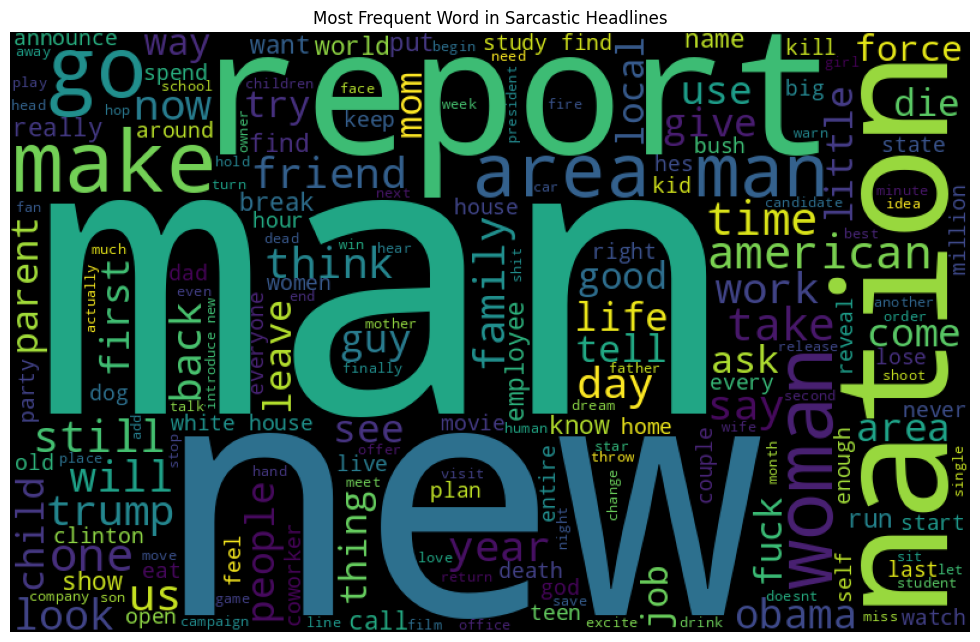

In [ ]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height = 500, background_color = 'black',
                      min_font_size = 10).generate(sarcasm_doc)

plt.figure(figsize = (10, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.title("Most Frequent Word in Sarcastic Headlines")
plt.show()

## Most Frequent Word in Non-Sarcastic Headlines

In [ ]:
notsarcasm_doc = ' '.join(word for word in df[df['is_sarcastic']==0]['headline_cleaned'])

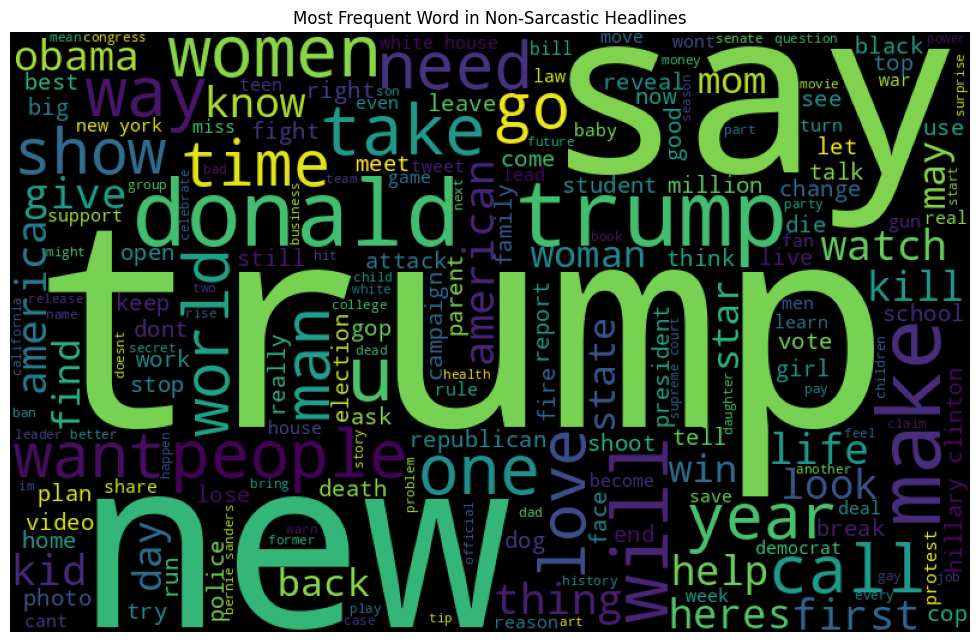

In [ ]:
wordcloud = WordCloud(width = 800, height = 500, background_color = 'black',
                      min_font_size = 10).generate(notsarcasm_doc)

plt.figure(figsize = (10, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.title("Most Frequent Word in Non-Sarcastic Headlines")
plt.show()

## Label

In [ ]:
df['is_sarcastic'].value_counts()

0    14951
1    11651
Name: is_sarcastic, dtype: int64

In [ ]:
df['is_sarcastic'].value_counts()*100/sum(df['is_sarcastic'].value_counts())

0    56.202541
1    43.797459
Name: is_sarcastic, dtype: float64

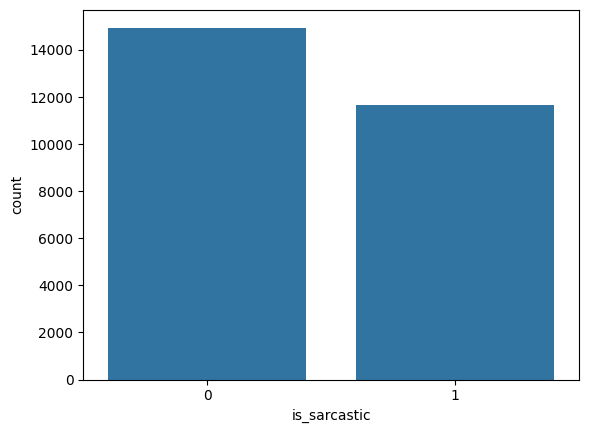

In [ ]:
# Let's see some visuals
import seaborn as sns
sns.countplot(x = df['is_sarcastic'])
plt.show()

Karena jumlah label tidak terlalu berbeda jauh, maka tidak perlu dilakukan penangangan imbalanced data.

# Modeling

In [ ]:
# Train test split
from sklearn.model_selection import train_test_split
# Text preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional

## Split Data

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df['headline_cleaned'], df['is_sarcastic'], test_size = 0.2,
                                                    random_state = 434, stratify = df['is_sarcastic'])
# stratify: ensures that the class distribution is maintained in splits

In [ ]:
y_train.value_counts(), y_test.value_counts()

(0    11960
 1     9321
 Name: is_sarcastic, dtype: int64,
 0    2991
 1    2330
 Name: is_sarcastic, dtype: int64)

## Tokenization

In [ ]:
from collections import Counter
# Count unique words
def counter_word(text_col):
  count = Counter()
  for text in text_col.values:
    for word in text.split():
      count[word] += 1
  return count
counter = counter_word(df['headline_cleaned'])

In [ ]:
len(counter)

22971

In [ ]:
counter.most_common(20)

[('to', 8196),
 ('of', 5599),
 ('the', 5365),
 ('in', 4180),
 ('be', 4024),
 ('for', 3298),
 ('a', 2996),
 ('on', 2388),
 ('and', 1912),
 ('with', 1796),
 ('trump', 1650),
 ('new', 1513),
 ('man', 1377),
 ('have', 1261),
 ('from', 1205),
 ('at', 1188),
 ('about', 1054),
 ('you', 994),
 ('get', 919),
 ('by', 886)]

In [ ]:
# Defining preprocessing parameters
max_len = 15 # Maximum number of words in a headline to use
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # Out of vocabulary token
# vocab_size = len(counter)
vocab_size = 30000
embedding_dim = 100 # How big is each word vector

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, char_level = False, oov_token = oov_tok)
tokenizer.fit_on_texts(x_train)

In [ ]:
# Get the word_index
word_index = tokenizer.word_index
total_words = len(word_index)
total_words

20592

## Sequence dan Padding

In [ ]:
# Train data
training_sequences = tokenizer.texts_to_sequences(x_train)
X_train = pad_sequences(training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type)
# Test data
testing_sequences = tokenizer.texts_to_sequences(x_test)
X_test = pad_sequences(testing_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type)

In [ ]:
print('Shape of training tensor: ', X_train.shape)
print('Shape of testing tensor: ', X_test.shape)

Shape of training tensor:  (21281, 15)
Shape of testing tensor:  (5321, 15)


In [ ]:
x_test[:4]

2674                         skywriter leave suicide note
23551    man stay up most of night rock cat back to sleep
8375                      sympathy card sign by assistant
17758              this be what divorce at be really like
Name: headline_cleaned, dtype: object

In [ ]:
X_test[:4]

array([[   1,  126,  947, 1217,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [  14,  525,   28,  115,    3,  285,  408,  455,   78,    2,  381,
           0,    0,    0,    0],
       [4829,  632,  323,   21, 3425,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [  22,    6,   35,  857,   17,    6,  143,   58,    0,    0,    0,
           0,    0,    0,    0]], dtype=int32)

## Simple Recurrent Neural Network (RNN)

In [ ]:
from keras.layers import SimpleRNN
from keras.layers import GlobalMaxPooling1D
# Define model architecture
model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_dim, input_length = max_len))
model1.add(Dropout(0.2))
model1.add(SimpleRNN(32, dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True))
model1.add(GlobalMaxPooling1D())
# First Dense layer with 16 neurons and ReLU activation
model1.add(Dense(16, activation = 'relu'))
# Dropout layer to prevent overfitting
model1.add(Dropout(0.2))
model1.add(Dense(1, activation = 'sigmoid'))

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 100)           3000000   
                                                                 
 dropout (Dropout)           (None, 15, 100)           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 15, 32)            4256      
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                        

In [ ]:
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])

In [ ]:
num_epochs = 5
batch_s = 32
from keras.callbacks import ReduceLROnPlateau
early_stop = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 2)

In [ ]:
history1 = model1.fit(X_train, y_train, epochs = num_epochs, batch_size = batch_s,
                      validation_data = (X_test, y_test), callbacks = [early_stop], verbose = 2)

Epoch 1/5
666/666 - 36s - loss: 0.4900 - accuracy: 0.7651 - val_loss: 0.3753 - val_accuracy: 0.8380 - lr: 0.0010 - 36s/epoch - 54ms/step
Epoch 2/5
666/666 - 29s - loss: 0.3000 - accuracy: 0.8858 - val_loss: 0.3603 - val_accuracy: 0.8444 - lr: 0.0010 - 29s/epoch - 44ms/step
Epoch 3/5
666/666 - 31s - loss: 0.2057 - accuracy: 0.9277 - val_loss: 0.3812 - val_accuracy: 0.8378 - lr: 0.0010 - 31s/epoch - 47ms/step
Epoch 4/5
666/666 - 32s - loss: 0.1610 - accuracy: 0.9435 - val_loss: 0.4278 - val_accuracy: 0.8344 - lr: 0.0010 - 32s/epoch - 48ms/step
Epoch 5/5
666/666 - 31s - loss: 0.1024 - accuracy: 0.9682 - val_loss: 0.4646 - val_accuracy: 0.8327 - lr: 1.0000e-04 - 31s/epoch - 46ms/step


167/167 [==============================] - 1s 3ms/step
Confusion Matrix:
[[2583  408]
 [ 482 1848]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      2991
           1       0.82      0.79      0.81      2330

    accuracy                           0.83      5321
   macro avg       0.83      0.83      0.83      5321
weighted avg       0.83      0.83      0.83      5321



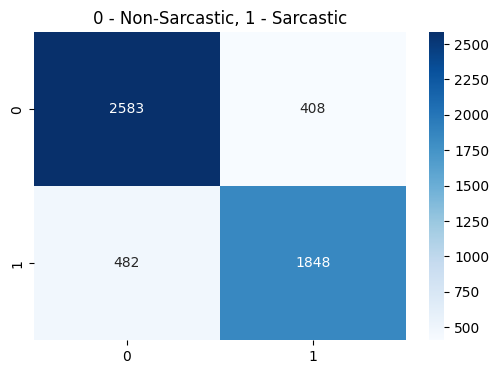

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

# Get predictions on the test set using the original model
y_pred1 = model1.predict(X_test)
y_pred_classes1 = (y_pred1>0.5).astype('int') # Assuming a binary classification threshold of 0.5

# Calculate confusion matrix
conf_matrix1 = confusion_matrix(y_test, y_pred_classes1)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix1)

# Calculate and print classification report
class_report1 = classification_report(y_test, y_pred_classes1)
print("\nClassification Report:")
print(class_report1)

# Plot confusion matrix
plt.figure(figsize = (6, 4))
sns.heatmap(conf_matrix1, annot = True, fmt = 'd', cmap = 'Blues')
plt.title("0 - Non-Sarcastic, 1 - Sarcastic")
plt.show()

## Long Short-Term Memory (Bi-LSTM)

In [ ]:
model2 = Sequential()
model2.add(Embedding(vocab_size, embedding_dim, input_length = max_len))
model2.add(Dropout(0.2))
model2.add(LSTM(32, dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True))
model2.add(GlobalMaxPooling1D())
# First dense layer with 16 neurons and ReLU activation
model2.add(Dense(16, activation = 'relu'))
# Dropout layer to prevent overfitting
model2.add(Dropout(0.2))
model2.add(Dense(1, activation = 'sigmoid'))

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 15, 100)           3000000   
                                                                 
 dropout_2 (Dropout)         (None, 15, 100)           0         
                                                                 
 lstm (LSTM)                 (None, 15, 32)            17024     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 32)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                      

In [ ]:
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
history2 = model2.fit(X_train, y_train, epochs = num_epochs, batch_size = batch_s,
                      validation_data = (X_test, y_test), callbacks = [early_stop], verbose = 2)

Epoch 1/5
666/666 - 44s - loss: 0.4305 - accuracy: 0.7943 - val_loss: 0.3351 - val_accuracy: 0.8491 - lr: 0.0010 - 44s/epoch - 66ms/step
Epoch 2/5
666/666 - 40s - loss: 0.2430 - accuracy: 0.9036 - val_loss: 0.3639 - val_accuracy: 0.8487 - lr: 0.0010 - 40s/epoch - 60ms/step
Epoch 3/5
666/666 - 41s - loss: 0.1572 - accuracy: 0.9407 - val_loss: 0.4477 - val_accuracy: 0.8416 - lr: 0.0010 - 41s/epoch - 61ms/step
Epoch 4/5
666/666 - 41s - loss: 0.0800 - accuracy: 0.9713 - val_loss: 0.5095 - val_accuracy: 0.8453 - lr: 1.0000e-04 - 41s/epoch - 61ms/step
Epoch 5/5
666/666 - 40s - loss: 0.0668 - accuracy: 0.9760 - val_loss: 0.5577 - val_accuracy: 0.8466 - lr: 1.0000e-04 - 40s/epoch - 60ms/step


167/167 [==============================] - 1s 4ms/step
Confusion Matrix:
[[2604  387]
 [ 429 1901]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      2991
           1       0.83      0.82      0.82      2330

    accuracy                           0.85      5321
   macro avg       0.84      0.84      0.84      5321
weighted avg       0.85      0.85      0.85      5321



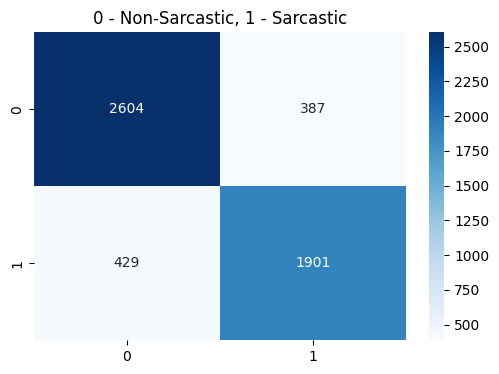

In [ ]:
# Confusion matrix

# Get predictions on the test set using the original model
y_pred2 = model2.predict(X_test)
y_pred_classes2 = (y_pred2>0.5).astype('int') # Assuming a binary classification threshold of 0.5

# Calculate confusion matrix
conf_matrix2 = confusion_matrix(y_test, y_pred_classes2)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix2)

# Calculate and print classification report
class_report2 = classification_report(y_test, y_pred_classes2)
print("\nClassification Report:")
print(class_report2)

# Plot confusion matrix
plt.figure(figsize = (6, 4))
sns.heatmap(conf_matrix2, annot = True, fmt = 'd', cmap = 'Blues')
plt.title("0 - Non-Sarcastic, 1 - Sarcastic")
plt.show()

## Bidirectional Long Short-Term Memory (Bi-LSTM)

In [ ]:
model3 = Sequential()
model3.add(Embedding(vocab_size, embedding_dim, input_length = max_len))
model3.add(Dropout(0.2))
model3.add(Bidirectional(LSTM(32, dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True)))
model3.add(GlobalMaxPooling1D())
# First dense layer with 16 neurons and ReLU activation
model3.add(Dense(16, activation = 'relu'))
# Dropout layer to prevent overfitting
model3.add(Dropout(0.2))
model3.add(Dense(1, activation = 'sigmoid'))

In [ ]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 15, 100)           3000000   
                                                                 
 dropout_4 (Dropout)         (None, 15, 100)           0         
                                                                 
 bidirectional (Bidirection  (None, 15, 64)            34048     
 al)                                                             
                                                                 
 global_max_pooling1d_2 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 16)                1040      
                                                                 
 dropout_5 (Dropout)         (None, 16)               

In [ ]:
model3.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
history3 = model3.fit(X_train, y_train, epochs = num_epochs, batch_size = batch_s,
                      validation_data = (X_test, y_test), callbacks = [early_stop], verbose = 2)

Epoch 1/5
666/666 - 56s - loss: 0.4204 - accuracy: 0.7989 - val_loss: 0.3295 - val_accuracy: 0.8517 - lr: 0.0010 - 56s/epoch - 84ms/step
Epoch 2/5
666/666 - 48s - loss: 0.2235 - accuracy: 0.9147 - val_loss: 0.3365 - val_accuracy: 0.8538 - lr: 0.0010 - 48s/epoch - 73ms/step
Epoch 3/5
666/666 - 49s - loss: 0.1323 - accuracy: 0.9545 - val_loss: 0.3858 - val_accuracy: 0.8528 - lr: 0.0010 - 49s/epoch - 73ms/step
Epoch 4/5
666/666 - 49s - loss: 0.0616 - accuracy: 0.9805 - val_loss: 0.4656 - val_accuracy: 0.8551 - lr: 1.0000e-04 - 49s/epoch - 74ms/step
Epoch 5/5
666/666 - 50s - loss: 0.0485 - accuracy: 0.9847 - val_loss: 0.5068 - val_accuracy: 0.8540 - lr: 1.0000e-04 - 50s/epoch - 75ms/step


167/167 [==============================] - 1s 6ms/step
Confusion Matrix:
[[2644  347]
 [ 430 1900]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      2991
           1       0.85      0.82      0.83      2330

    accuracy                           0.85      5321
   macro avg       0.85      0.85      0.85      5321
weighted avg       0.85      0.85      0.85      5321



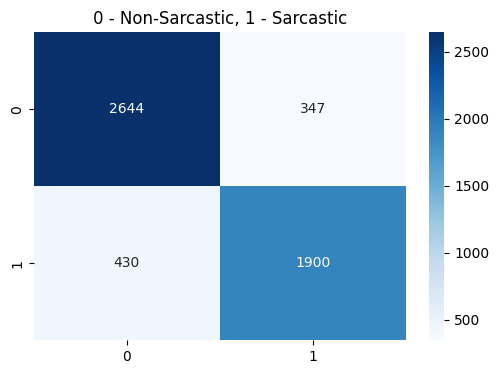

In [ ]:
# Confusion matrix

# Get predictions on the test set using the original model
y_pred3 = model3.predict(X_test)
y_pred_classes3 = (y_pred3>0.5).astype('int') # Assuming a binary classification threshold of 0.5

# Calculate confusion matrix
conf_matrix3 = confusion_matrix(y_test, y_pred_classes3)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix3)

# Calculate and print classification report
class_report3 = classification_report(y_test, y_pred_classes3)
print("\nClassification Report:")
print(class_report3)

# Plot confusion matrix
plt.figure(figsize = (6, 4))
sns.heatmap(conf_matrix3, annot = True, fmt = 'd', cmap = 'Blues')
plt.title("0 - Non-Sarcastic, 1 - Sarcastic")
plt.show()

## Gated Recurrent Unit (GRU)

In [ ]:
model4 = Sequential()
model4.add(Embedding(vocab_size, embedding_dim, input_length = max_len))
model4.add(Dropout(0.2))
model4.add(GRU(32, dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True))
model4.add(GlobalMaxPooling1D())
# First dense layer with 16 neurons and ReLU activation
model4.add(Dense(16, activation = 'relu'))
# Dropout layer to prevent overfitting
model4.add(Dropout(0.2))
model4.add(Dense(1, activation = 'sigmoid'))

In [ ]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 15, 100)           3000000   
                                                                 
 dropout_6 (Dropout)         (None, 15, 100)           0         
                                                                 
 gru (GRU)                   (None, 15, 32)            12864     
                                                                 
 global_max_pooling1d_3 (Gl  (None, 32)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dropout_7 (Dropout)         (None, 16)                0         
                                                      

In [ ]:
model4.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
history4 = model4.fit(X_train, y_train, epochs = num_epochs, batch_size = batch_s,
                      validation_data = (X_test, y_test), callbacks = [early_stop], verbose = 2)

Epoch 1/5
666/666 - 42s - loss: 0.4472 - accuracy: 0.7834 - val_loss: 0.3473 - val_accuracy: 0.8444 - lr: 0.0010 - 42s/epoch - 64ms/step
Epoch 2/5
666/666 - 39s - loss: 0.2562 - accuracy: 0.9006 - val_loss: 0.3443 - val_accuracy: 0.8493 - lr: 0.0010 - 39s/epoch - 58ms/step
Epoch 3/5
666/666 - 38s - loss: 0.1698 - accuracy: 0.9375 - val_loss: 0.3878 - val_accuracy: 0.8369 - lr: 0.0010 - 38s/epoch - 57ms/step
Epoch 4/5
666/666 - 37s - loss: 0.1188 - accuracy: 0.9601 - val_loss: 0.4495 - val_accuracy: 0.8427 - lr: 0.0010 - 37s/epoch - 56ms/step
Epoch 5/5
666/666 - 37s - loss: 0.0656 - accuracy: 0.9802 - val_loss: 0.5117 - val_accuracy: 0.8412 - lr: 1.0000e-04 - 37s/epoch - 56ms/step


167/167 [==============================] - 1s 3ms/step
Confusion Matrix:
[[2576  415]
 [ 430 1900]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      2991
           1       0.82      0.82      0.82      2330

    accuracy                           0.84      5321
   macro avg       0.84      0.84      0.84      5321
weighted avg       0.84      0.84      0.84      5321



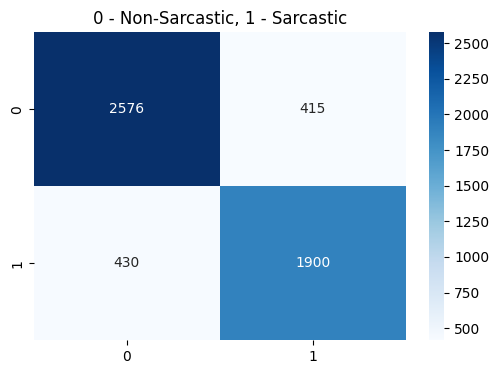

In [ ]:
# Confusion matrix

# Get predictions on the test set using the original model
y_pred4 = model4.predict(X_test)
y_pred_classes4 = (y_pred4>0.5).astype('int') # Assuming a binary classification threshold of 0.5

# Calculate confusion matrix
conf_matrix4 = confusion_matrix(y_test, y_pred_classes4)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix4)

# Calculate and print classification report
class_report4 = classification_report(y_test, y_pred_classes4)
print("\nClassification Report:")
print(class_report4)

# Plot confusion matrix
plt.figure(figsize = (6, 4))
sns.heatmap(conf_matrix4, annot = True, fmt = 'd', cmap = 'Blues')
plt.title("0 - Non-Sarcastic, 1 - Sarcastic")
plt.show()

## Bidirectional Gated Recurrent Unit (Bi-GRU)

In [ ]:
model5 = Sequential()
model5.add(Embedding(vocab_size, embedding_dim, input_length = max_len))
model5.add(Dropout(0.2))
model5.add(Bidirectional(GRU(32, dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True)))
model5.add(GlobalMaxPooling1D())
# First dense layer with 16 neurons and ReLU activation
model5.add(Dense(16, activation = 'relu'))
# Dropout layer to prevent overfitting
model5.add(Dropout(0.2))
model5.add(Dense(1, activation = 'sigmoid'))

In [ ]:
model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 15, 100)           3000000   
                                                                 
 dropout_8 (Dropout)         (None, 15, 100)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 15, 64)            25728     
 onal)                                                           
                                                                 
 global_max_pooling1d_4 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_8 (Dense)             (None, 16)                1040      
                                                                 
 dropout_9 (Dropout)         (None, 16)               

In [ ]:
model5.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
history5 = model5.fit(X_train, y_train, epochs = num_epochs, batch_size = batch_s,
                      validation_data = (X_test, y_test), callbacks = [early_stop], verbose = 2)

Epoch 1/5
666/666 - 53s - loss: 0.4355 - accuracy: 0.7891 - val_loss: 0.3424 - val_accuracy: 0.8506 - lr: 0.0010 - 53s/epoch - 80ms/step
Epoch 2/5
666/666 - 48s - loss: 0.2334 - accuracy: 0.9099 - val_loss: 0.3482 - val_accuracy: 0.8527 - lr: 0.0010 - 48s/epoch - 73ms/step
Epoch 3/5
666/666 - 49s - loss: 0.1372 - accuracy: 0.9499 - val_loss: 0.3840 - val_accuracy: 0.8521 - lr: 0.0010 - 49s/epoch - 74ms/step
Epoch 4/5
666/666 - 48s - loss: 0.0681 - accuracy: 0.9801 - val_loss: 0.4501 - val_accuracy: 0.8478 - lr: 1.0000e-04 - 48s/epoch - 72ms/step
Epoch 5/5
666/666 - 48s - loss: 0.0549 - accuracy: 0.9842 - val_loss: 0.4931 - val_accuracy: 0.8463 - lr: 1.0000e-04 - 48s/epoch - 72ms/step


167/167 [==============================] - 2s 6ms/step
Confusion Matrix:
[[2620  371]
 [ 447 1883]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      2991
           1       0.84      0.81      0.82      2330

    accuracy                           0.85      5321
   macro avg       0.84      0.84      0.84      5321
weighted avg       0.85      0.85      0.85      5321



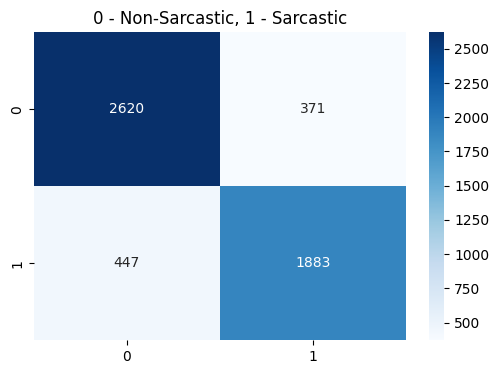

In [ ]:
# Confusion matrix

# Get predictions on the test set using the original model
y_pred5 = model5.predict(X_test)
y_pred_classes5 = (y_pred5>0.5).astype('int') # Assuming a binary classification threshold of 0.5

# Calculate confusion matrix
conf_matrix5 = confusion_matrix(y_test, y_pred_classes5)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix5)

# Calculate and print classification report
class_report5 = classification_report(y_test, y_pred_classes5)
print("\nClassification Report:")
print(class_report5)

# Plot confusion matrix
plt.figure(figsize = (6, 4))
sns.heatmap(conf_matrix5, annot = True, fmt = 'd', cmap = 'Blues')
plt.title("0 - Non-Sarcastic, 1 - Sarcastic")
plt.show()

## Convolutional Neural Network (CNN)

In [ ]:
from keras.layers import Conv1D

In [ ]:
# Building the CNN Model
model6 = Sequential()
model6.add(Embedding(vocab_size, embedding_dim, input_length = max_len))
model6.add(Dropout(0.2))
model6.add(Conv1D(32, 3, padding = 'same', activation = 'relu'))
model6.add(GlobalMaxPooling1D())
# First dense layer with 16 neurons and ReLU activation
model6.add(Dense(16, activation = 'relu'))
# Dropout layer to prevent overfitting
model6.add(Dropout(0.2))
model6.add(Dense(1, activation = 'sigmoid'))

In [ ]:
model6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 15, 100)           3000000   
                                                                 
 dropout_10 (Dropout)        (None, 15, 100)           0         
                                                                 
 conv1d (Conv1D)             (None, 15, 32)            9632      
                                                                 
 global_max_pooling1d_5 (Gl  (None, 32)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dropout_11 (Dropout)        (None, 16)                0         
                                                      

In [ ]:
model6.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
history6 = model6.fit(X_train, y_train, epochs = num_epochs, batch_size = batch_s,
                      validation_data = (X_test, y_test), callbacks = [early_stop], verbose = 2)

Epoch 1/5
666/666 - 29s - loss: 0.4615 - accuracy: 0.7760 - val_loss: 0.3532 - val_accuracy: 0.8436 - lr: 0.0010 - 29s/epoch - 44ms/step
Epoch 2/5
666/666 - 28s - loss: 0.2271 - accuracy: 0.9145 - val_loss: 0.3537 - val_accuracy: 0.8542 - lr: 0.0010 - 28s/epoch - 43ms/step
Epoch 3/5
666/666 - 29s - loss: 0.0948 - accuracy: 0.9686 - val_loss: 0.4114 - val_accuracy: 0.8495 - lr: 0.0010 - 29s/epoch - 44ms/step
Epoch 4/5
666/666 - 28s - loss: 0.0330 - accuracy: 0.9925 - val_loss: 0.4366 - val_accuracy: 0.8523 - lr: 1.0000e-04 - 28s/epoch - 43ms/step
Epoch 5/5
666/666 - 29s - loss: 0.0247 - accuracy: 0.9943 - val_loss: 0.4610 - val_accuracy: 0.8523 - lr: 1.0000e-04 - 29s/epoch - 43ms/step


167/167 [==============================] - 0s 2ms/step
Confusion Matrix:
[[2649  342]
 [ 444 1886]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      2991
           1       0.85      0.81      0.83      2330

    accuracy                           0.85      5321
   macro avg       0.85      0.85      0.85      5321
weighted avg       0.85      0.85      0.85      5321



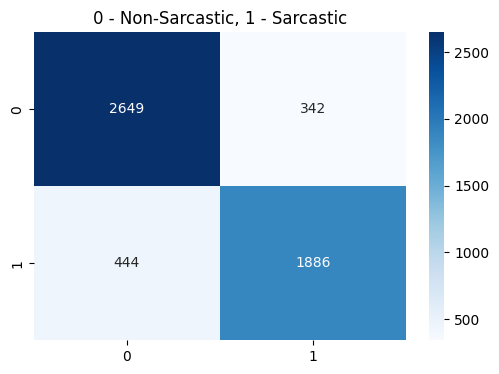

In [ ]:
# Confusion matrix

# Get predictions on the test set using the original model
y_pred6 = model6.predict(X_test)
y_pred_classes6 = (y_pred6>0.5).astype('int') # Assuming a binary classification threshold of 0.5

# Calculate confusion matrix
conf_matrix6 = confusion_matrix(y_test, y_pred_classes6)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix6)

# Calculate and print classification report
class_report6 = classification_report(y_test, y_pred_classes6)
print("\nClassification Report:")
print(class_report6)

# Plot confusion matrix
plt.figure(figsize = (6, 4))
sns.heatmap(conf_matrix6, annot = True, fmt = 'd', cmap = 'Blues')
plt.title("0 - Non-Sarcastic, 1 - Sarcastic")
plt.show()

## Perbandingan Performance

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
def metric(y_true, y_pred):
  ac = accuracy_score(y_true, y_pred)
  pr = precision_score(y_true, y_pred)
  rc = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  return(dict({'Accuracy': ac, 'Precision': pr, 'Recall': rc, 'F-1 Score': f1}))

In [ ]:
metric1 = metric(y_test, y_pred_classes1)
metric2 = metric(y_test, y_pred_classes2)
metric3 = metric(y_test, y_pred_classes3)
metric4 = metric(y_test, y_pred_classes4)
metric5 = metric(y_test, y_pred_classes5)
metric6 = metric(y_test, y_pred_classes6)
df_metric = pd.DataFrame(columns = ['Accuracy', 'Precision', 'Recall', 'F-1 Score'])
def append_dict_to_df(df, dict_to_append):
    df = pd.concat([df, pd.DataFrame.from_records([dict_to_append])])
    return df
df_metric = append_dict_to_df(df_metric, metric1)
df_metric = append_dict_to_df(df_metric, metric2)
df_metric = append_dict_to_df(df_metric, metric3)
df_metric = append_dict_to_df(df_metric, metric4)
df_metric = append_dict_to_df(df_metric, metric5)
df_metric = append_dict_to_df(df_metric, metric6)
df_metric['Model'] = ['Simple RNN', 'LSTM', 'Bi-LSTM', 'GRU', 'Bi-GRU', 'CNN']
df_metric

,Accuracy,Precision,Recall,F-1 Score,Model
0,0.832738,0.819149,0.793133,0.805931,Simple RNN
0,0.846645,0.830857,0.815880,0.823300,LSTM
0,0.853975,0.845572,0.815451,0.830238,Bi-LSTM
0,0.841195,0.820734,0.815451,0.818084,GRU
0,0.846269,0.835404,0.808155,0.821553,Bi-GRU
0,0.852283,0.846499,0.809442,0.827556,CNN


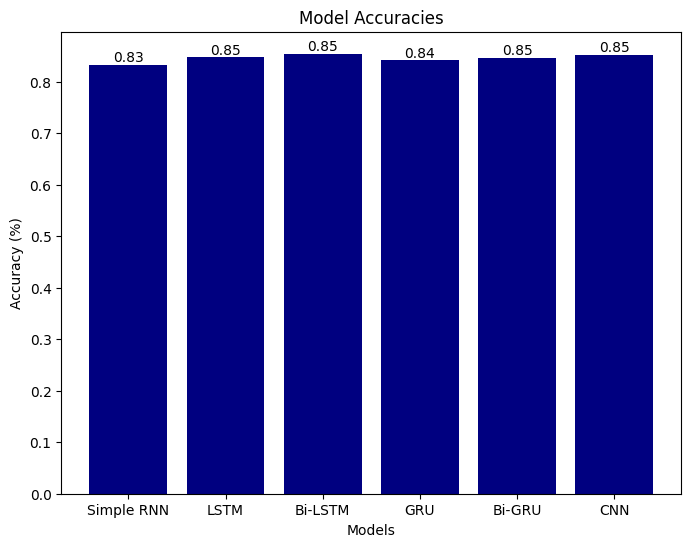

In [ ]:
# Sample accuracy values
accuracies = df_metric['Accuracy']
# Labels for each model
labels = df_metric['Model']
# Create a bar chart
plt.figure(figsize = (8, 6)) # Set the size of the plot
bars = plt.bar(labels, accuracies, color = 'navy')  # Plot bars with labels and accuracy values

# Adding data labels above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha = 'center', va = 'bottom')

# Adding title and labels
plt.title('Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')

# Display the plot
plt.show()

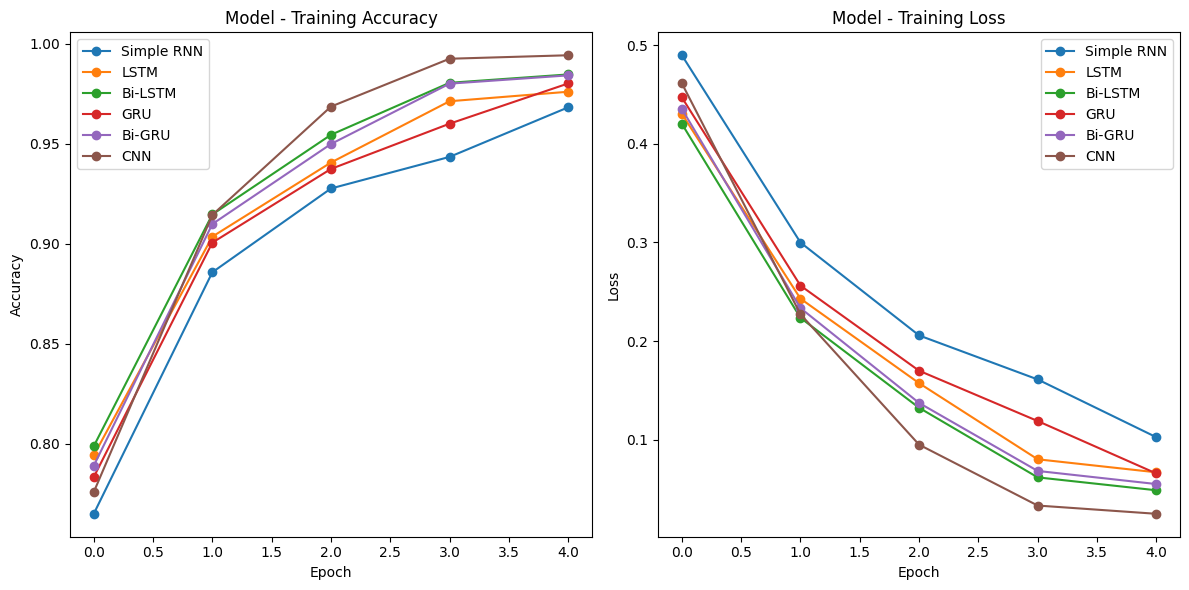

In [ ]:
# Plot accuracy
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label = 'Simple RNN', marker = 'o')
plt.plot(history2.history['accuracy'], label = 'LSTM', marker = 'o')
plt.plot(history3.history['accuracy'], label = 'Bi-LSTM', marker = 'o')
plt.plot(history4.history['accuracy'], label = 'GRU', marker = 'o')
plt.plot(history5.history['accuracy'], label = 'Bi-GRU', marker = 'o')
plt.plot(history6.history['accuracy'], label = 'CNN', marker = 'o')
plt.title('Model - Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label = 'Simple RNN', marker = 'o')
plt.plot(history2.history['loss'], label = 'LSTM', marker = 'o')
plt.plot(history3.history['loss'], label = 'Bi-LSTM', marker = 'o')
plt.plot(history4.history['loss'], label = 'GRU', marker = 'o')
plt.plot(history5.history['loss'], label = 'Bi-GRU', marker = 'o')
plt.plot(history6.history['loss'], label = 'CNN', marker = 'o')
plt.title('Model - Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

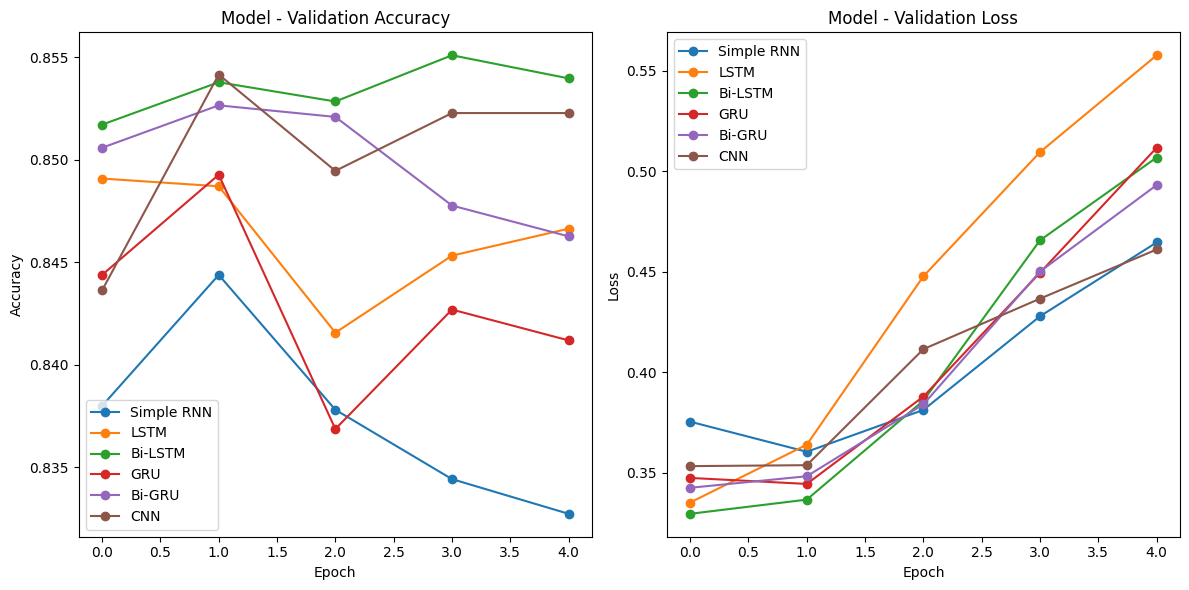

In [ ]:
# Plot validation accuracy
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.plot(history1.history['val_accuracy'], label = 'Simple RNN', marker = 'o')
plt.plot(history2.history['val_accuracy'], label = 'LSTM', marker = 'o')
plt.plot(history3.history['val_accuracy'], label = 'Bi-LSTM', marker = 'o')
plt.plot(history4.history['val_accuracy'], label = 'GRU', marker = 'o')
plt.plot(history5.history['val_accuracy'], label = 'Bi-GRU', marker = 'o')
plt.plot(history6.history['val_accuracy'], label = 'CNN', marker = 'o')
plt.title('Model - Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot validation loss
plt.subplot(1, 2, 2)
plt.plot(history1.history['val_loss'], label = 'Simple RNN', marker = 'o')
plt.plot(history2.history['val_loss'], label = 'LSTM', marker = 'o')
plt.plot(history3.history['val_loss'], label = 'Bi-LSTM', marker = 'o')
plt.plot(history4.history['val_loss'], label = 'GRU', marker = 'o')
plt.plot(history5.history['val_loss'], label = 'Bi-GRU', marker = 'o')
plt.plot(history6.history['val_loss'], label = 'CNN', marker = 'o')
plt.title('Model - Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()